In [206]:
%load_ext autoreload
%autoreload 2
from helper import create_tsp_graph,plot_tsp_graph,bitstring_to_path,cost
from classical import solve_tsp_classical
from alternating_operator import get_expectation,analyse_result,create_qaoa_circ
from scipy.optimize import minimize
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
G = create_tsp_graph(5)

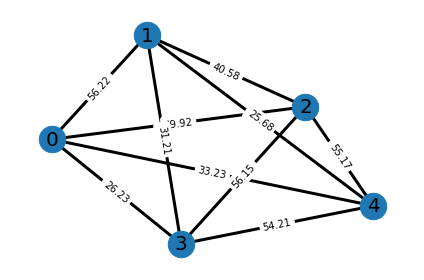

In [236]:
plot_tsp_graph(G)

In [237]:
reps = 2
expectation = get_expectation(G,reps,shots=1024)

res = minimize(expectation,
               [1 for _ in range(reps*4)] ,
                      method='COBYLA',
                      options = {'tol' : 1,'disp' : True})

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


Current expected cost: 221.83
Current expected cost: 221.83
Current expected cost: 221.83
Current expected cost: 221.83
Current expected cost: 221.83
Current expected cost: 222.85
Current expected cost: 215.96
Current expected cost: 215.96
Current expected cost: 214.28
Current expected cost: 240.03
Current expected cost: 239.13
Current expected cost: 214.28
Current expected cost: 222.31
Current expected cost: 214.28
Current expected cost: 223.67
Current expected cost: 214.28
Current expected cost: 226.26
Current expected cost: 234.46
Current expected cost: 219.01
Current expected cost: 217.03
Current expected cost: 230.02
Current expected cost: 215.47
Current expected cost: 238.2
Current expected cost: 238.1
Current expected cost: 214.28
Current expected cost: 230.97
Current expected cost: 214.28
Current expected cost: 206.72
Current expected cost: 206.72
Current expected cost: 237.45
Current expected cost: 225.86
Current expected cost: 215.2
Current expected cost: 230.62
Current expec

In [238]:
res

     fun: 203.92592841071405
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 86
  status: 1
 success: True
       x: array([1.01114178, 1.00819364, 1.00551328, 1.00619723, 1.00169781,
       1.99126439, 1.00266879, 2.06117679])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


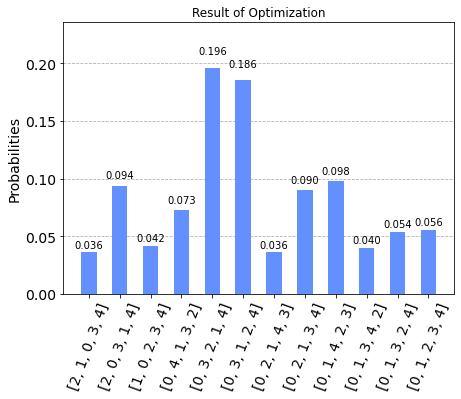

In [239]:
fig,counts = analyse_result(G,res.x,reps=reps,transform_labels_to_path=True,filter_unique_path=True)
fig

In [241]:
for key, val in counts.items():
    if val>1:
        path = bitstring_to_path(key)
        print(path,':', val , f"   cost = {round(cost(G,path),2)}")

[0, 1, 2, 3, 4] : 57    cost = 240.4
[2, 1, 0, 3, 4] : 37    cost = 232.42
[0, 3, 1, 2, 4] : 190    cost = 186.44
[0, 3, 2, 1, 4] : 201    cost = 181.88
[0, 1, 3, 4, 2] : 41    cost = 246.74
[2, 0, 3, 1, 4] : 96    cost = 188.22
[0, 4, 1, 3, 2] : 75    cost = 196.2
[1, 0, 2, 3, 4] : 43    cost = 242.18
[0, 2, 1, 3, 4] : 92    cost = 209.16
[0, 1, 4, 2, 3] : 100    cost = 219.46
[0, 2, 1, 4, 3] : 37    cost = 196.63
[0, 1, 3, 2, 4] : 55    cost = 231.99


In [162]:
from itertools import permutations
for p in permutations([0,1,2,3]):
    print(p,':',cost(G,p))

(0, 1, 2, 3) : 257.58468491597694
(0, 1, 3, 2) : 225.93662157582426
(0, 2, 1, 3) : 204.47802161445287
(0, 2, 3, 1) : 225.93662157582426
(0, 3, 1, 2) : 204.47802161445284
(0, 3, 2, 1) : 257.58468491597694
(1, 0, 2, 3) : 225.93662157582423
(1, 0, 3, 2) : 257.58468491597694
(1, 2, 0, 3) : 204.47802161445287
(1, 2, 3, 0) : 257.58468491597694
(1, 3, 0, 2) : 204.47802161445287
(1, 3, 2, 0) : 225.93662157582426
(2, 0, 1, 3) : 225.93662157582423
(2, 0, 3, 1) : 204.47802161445287
(2, 1, 0, 3) : 257.58468491597694
(2, 1, 3, 0) : 204.47802161445284
(2, 3, 0, 1) : 257.58468491597694
(2, 3, 1, 0) : 225.93662157582426
(3, 0, 1, 2) : 257.58468491597694
(3, 0, 2, 1) : 204.47802161445287
(3, 1, 0, 2) : 225.93662157582423
(3, 1, 2, 0) : 204.47802161445287
(3, 2, 0, 1) : 225.93662157582426
(3, 2, 1, 0) : 257.58468491597694


In [240]:
solve_tsp_classical(G)

([0, 3, 2, 1, 4], 181.8807717313698)

In [122]:
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from alternating_operator import create_initial_state_circuit,create_mixer_operator,create_phase_separator
from qaoa import build_cost
from qiskit.circuit import Parameter
from qiskit import Aer

In [177]:
qaoa = QAOA(optimizer=COBYLA(),reps=1,initial_state =create_initial_state_circuit(4),mixer = create_mixer_operator(4),quantum_instance=Aer.get_backend('aer_simulator'))

In [181]:
cost_ham = build_cost(1.,3,G)

phase_sep = create_phase_separator(G)

params = [Parameter(str(i)) for i in range(reps*4)]

qc = qaoa.construct_circuit(params,phase_sep)[0]

In [153]:
res_2 = qaoa.compute_minimum_eigenvalue(create_phase_separator(G))

In [154]:
res_2

In [155]:
from collections import OrderedDict
import numpy as np
def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector (numpy.ndarray or dict): state vector or counts.
    Returns:
        numpy.ndarray: binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, (OrderedDict, dict)):
        # get the binary string with the largest count
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        #x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return binary_string
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x

In [156]:
x = sample_most_likely(res_2.eigenstate)

In [168]:
bitstring_to_path(x)

[2, 0, 1, 3]

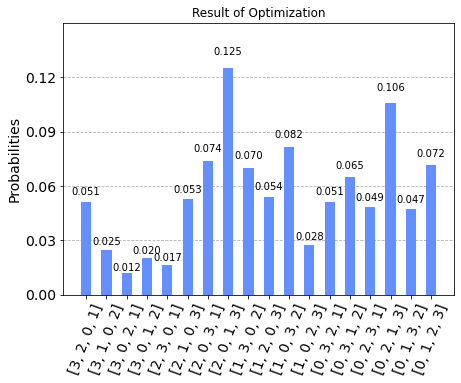

In [157]:
fig = plot_histogram(res_2.eigenstate, title='Result of Optimization')

ax = fig.axes
ax = ax[0]

labels = [bitstring_to_path(item.get_text(), return_as_string=True) for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

fig
    


In [129]:
for key, val in res_2.eigenstate.items():
    path = bitstring_to_path(key)
    print(path , f"   cost = {round(cost(G,path),2)}")

[3, 2, 0, 1]    cost = 225.94
[3, 1, 0, 2]    cost = 225.94
[3, 0, 2, 1]    cost = 204.48
[3, 0, 1, 2]    cost = 257.58
[2, 3, 0, 1]    cost = 257.58
[2, 1, 0, 3]    cost = 257.58
[2, 0, 3, 1]    cost = 204.48
[2, 0, 1, 3]    cost = 225.94
[1, 3, 0, 2]    cost = 204.48
[1, 2, 0, 3]    cost = 204.48
[1, 0, 3, 2]    cost = 257.58
[1, 0, 2, 3]    cost = 225.94
[0, 3, 2, 1]    cost = 257.58
[0, 3, 1, 2]    cost = 204.48
[0, 2, 3, 1]    cost = 225.94
[0, 2, 1, 3]    cost = 204.48
[0, 1, 3, 2]    cost = 225.94
[0, 1, 2, 3]    cost = 257.58
